In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [2]:
test_labels = np.load('../data/labels/test_labels.npy')
train_tracks = np.load("../data/tracks/train_tracks.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

train_tracks_features = train_tracks[:, 0, 4:17] 
test_tracks_features = test_tracks[:, 0, 4:17]

In [59]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools


# Define config
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'n_feature_pairs': 50  # number of random feature pairs to test
}

# Set seed
tf.keras.utils.set_random_seed(config['seed'])
np.random.seed(config['seed'])

# Initialize container for confusion matrices
conf_matrix_tabular = np.zeros((config['n_feature_pairs'], 2, 2))

# Loop over N random feature combinations
for i in range(config['n_feature_pairs']):
    # Pick 2 random features
    selected_features = np.random.choice(13, size=2, replace=False)
    print(f"Run {i+1} — Using features: {selected_features}")

    # Subset the data
    X_train = train_tracks_features[:, selected_features]
    X_test = test_tracks_features[:, selected_features]

    # Train/val split
    X_val, X_test_final, y_val, y_test_final = train_test_split(X_test, test_labels, test_size=0.5, random_state=42)

    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = dict(enumerate(class_weights))

    # Build model
    classifier = complex_mlp_classifier(latent_dim=2)
    classifier.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
                       metrics=['accuracy'])

    # Train
    classifier.fit(X_train, train_labels,
                   batch_size=config['batch_size'],
                   epochs=config['epochs'],
                   validation_data=(X_val, y_val),
                   class_weight=class_weights,
                   verbose=0)

    # Predict
    y_pred = classifier.predict(X_test_final, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test_final, y_pred_classes)
    cm_normalized = cm / cm.sum(axis=1, keepdims=True)

    conf_matrix_tabular[i] = cm_normalized

# Save results
#np.save("confusion_matrices_random_feature_selection.npy", conf_matrix_tabular)
#print(f"\nSaved confusion matrices for {config['n_feature_pairs']} random feature combinations.")


Run 1 — Using features: [11  9]
Run 2 — Using features: [ 8 10]
Run 3 — Using features: [12 10]
Run 4 — Using features: [9 1]
Run 5 — Using features: [0 5]
Run 6 — Using features: [8 9]
Run 7 — Using features: [4 2]
Run 8 — Using features: [11  2]
Run 9 — Using features: [5 1]
Run 10 — Using features: [11  9]
Run 11 — Using features: [ 1 10]
Run 12 — Using features: [10  1]
Run 13 — Using features: [1 8]
Run 14 — Using features: [7 9]
Run 15 — Using features: [1 2]
Run 16 — Using features: [11  1]
Run 17 — Using features: [2 4]
Run 18 — Using features: [9 5]
Run 19 — Using features: [8 7]
Run 20 — Using features: [9 8]
Run 21 — Using features: [11  1]
Run 22 — Using features: [5 1]
Run 23 — Using features: [11  4]
Run 24 — Using features: [11  6]
Run 25 — Using features: [4 1]
Run 26 — Using features: [4 1]
Run 27 — Using features: [ 9 10]
Run 28 — Using features: [5 9]
Run 29 — Using features: [8 3]


KeyboardInterrupt: 

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# Define config
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
}

# Set seed
tf.keras.utils.set_random_seed(config['seed'])
np.random.seed(config['seed'])

# All unique feature pairs (13 choose 2 = 78)
feature_pairs = list(itertools.combinations(range(13), 2))
config['n_feature_pairs'] = len(feature_pairs)

# Initialize container for confusion matrices
conf_matrix_tabular = np.zeros((config['n_feature_pairs'], 2, 2))

# Loop over all unique feature combinations
for i, selected_features in enumerate(feature_pairs):
    print(f"Run {i+1}/{config['n_feature_pairs']} — Using features: {selected_features}")

    # Subset the data
    X_train = train_tracks_features[:, selected_features]
    X_test = test_tracks_features[:, selected_features]

    # Train/val split
    X_val, X_test_final, y_val, y_test_final = train_test_split(X_test, test_labels, test_size=0.5, random_state=42)

    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = dict(enumerate(class_weights))

    # Build model
    classifier = complex_mlp_classifier(latent_dim=2)
    classifier.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
                       metrics=['accuracy'])

    # Train
    classifier.fit(X_train, train_labels,
                   batch_size=config['batch_size'],
                   epochs=config['epochs'],
                   validation_data=(X_val, y_val),
                   class_weight=class_weights,
                   verbose=0)

    # Predict
    y_pred = classifier.predict(X_test_final, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test_final, y_pred_classes)
    cm_normalized = cm / cm.sum(axis=1, keepdims=True)
    conf_matrix_tabular[i] = cm_normalized

# Save results
# np.save("confusion_matrices_all_feature_combinations.npy", conf_matrix_tabular)


Run 1/78 — Using features: (0, 1)
Run 2/78 — Using features: (0, 2)
Run 3/78 — Using features: (0, 3)
Run 4/78 — Using features: (0, 4)
Run 5/78 — Using features: (0, 5)
Run 6/78 — Using features: (0, 6)
Run 7/78 — Using features: (0, 7)
Run 8/78 — Using features: (0, 8)
Run 9/78 — Using features: (0, 9)
Run 10/78 — Using features: (0, 10)
Run 11/78 — Using features: (0, 11)
Run 12/78 — Using features: (0, 12)
Run 13/78 — Using features: (1, 2)
Run 14/78 — Using features: (1, 3)
Run 15/78 — Using features: (1, 4)
Run 16/78 — Using features: (1, 5)
Run 17/78 — Using features: (1, 6)
Run 18/78 — Using features: (1, 7)
Run 19/78 — Using features: (1, 8)
Run 20/78 — Using features: (1, 9)
Run 21/78 — Using features: (1, 10)
Run 22/78 — Using features: (1, 11)
Run 23/78 — Using features: (1, 12)
Run 24/78 — Using features: (2, 3)
Run 25/78 — Using features: (2, 4)
Run 26/78 — Using features: (2, 5)
Run 27/78 — Using features: (2, 6)
Run 28/78 — Using features: (2, 7)
Run 29/78 — Using featu

In [ ]:
#np.save("conf_matrices_all_possible_feat_comb.npy", conf_matrix_tabular)

In [6]:
precision_tabular = np.zeros((conf_matrix_tabular.shape[0]))
accuracy_tabular = np.zeros((conf_matrix_tabular.shape[0]))
false_positives_tabular = np.zeros((conf_matrix_tabular.shape[0]))
false_negatives_tabular = np.zeros((conf_matrix_tabular.shape[0]))

for size in range(conf_matrix_tabular.shape[0]):
    conf_matrix = conf_matrix_tabular[size]
    precision_tabular[size] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
    accuracy_tabular[size] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
    false_positives_tabular[size] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
    false_negatives_tabular[size] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [16]:
np.arange(1, 31).shape

(30,)

In [ ]:
# np.save("precision_2feattabular.npy", precision_tabular)
# np.save("accuracy_2feattabular.npy", accuracy_tabular)
# np.save("false_positives_2feattabular.npy", false_positives_tabular)
# np.save("false_negatives_2feattabular.npy", false_negatives_tabular)

In [15]:
np.where(precision_tabular == precision_tabular.max())

(array([51]),)

In [21]:
precision_tabular[7]

0.7350835322195705

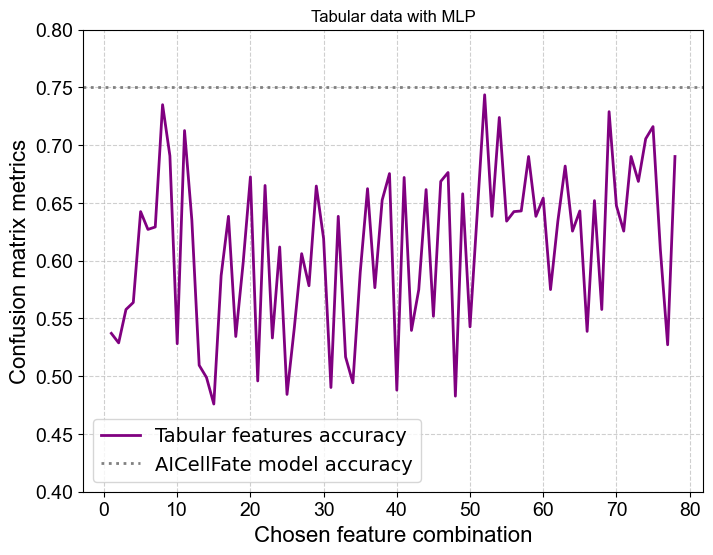

In [11]:
feature_pairs = np.arange(1, 79)

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
#plt.plot(feature_pairs, precision_tabular, color='orange', linewidth=2, label='Precision')

# Accuracy (purple)
plt.plot(feature_pairs, precision_tabular, color='purple', linewidth=2, label='Tabular features accuracy')

# Add horizontal dotted line for AICellFate model precision
#plt.axhline(y=0.745, color='orange', linestyle='dotted', linewidth=2, label='AICellFate model precision')
plt.axhline(y=0.75, color='gray', linestyle='dotted', linewidth=2, label='AICellFate model accuracy') ### this is the mean precision value from AICellFate on the first frame

# # False Positives (green)
# plt.plot(feature_pairs, false_positives_tabular, color='green', linewidth=2, label='False Positives')

# # False Negatives (blue)
# plt.plot(feature_pairs, false_negatives_tabular, color='blue', linewidth=2, label='False Negatives')

# Formatting
plt.xlabel("Chosen feature combination", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.4, 0.8)  # Set y-axis range
plt.title("Tabular data with MLP")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("accuracy_comparison.svg", dpi=300, bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


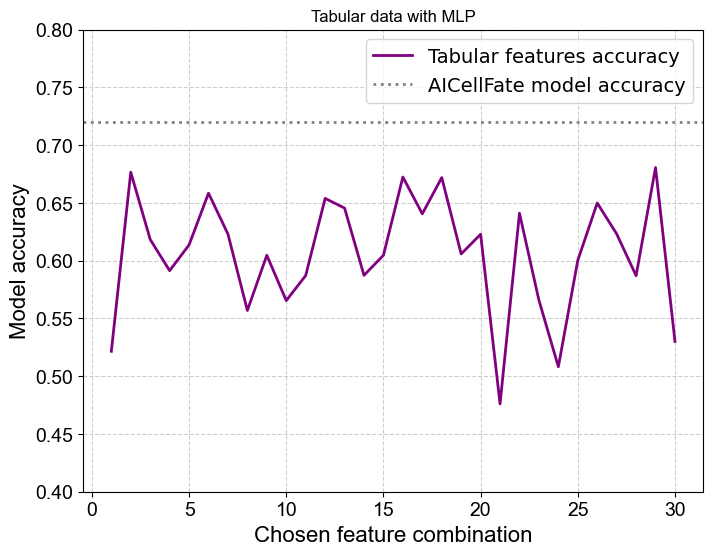

In [45]:
feature_pairs = np.arange(1, 31)

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
#plt.plot(feature_pairs, precision_tabular, color='orange', linewidth=2, label='Precision')

# Accuracy (purple)
plt.plot(feature_pairs, accuracy_tabular, color='purple', linewidth=2, label='Tabular features accuracy')

# Add horizontal dotted line for AICellFate model precision
#plt.axhline(y=0.745, color='orange', linestyle='dotted', linewidth=2, label='AICellFate model precision')
plt.axhline(y=0.72, color='gray', linestyle='dotted', linewidth=2, label='AICellFate model accuracy') ### this is the mean precision value from AICellFate on the first frame

# # False Positives (green)
# plt.plot(feature_pairs, false_positives_tabular, color='green', linewidth=2, label='False Positives')

# # False Negatives (blue)
# plt.plot(feature_pairs, false_negatives_tabular, color='blue', linewidth=2, label='False Negatives')

# Formatting
plt.xlabel("Chosen feature combination", fontsize=16, fontname="Arial")
plt.ylabel("Model accuracy", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.4, 0.8)  # Set y-axis range
plt.title("Tabular data with MLP")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
plt.savefig("accuracy_comparison.eps", dpi=300, bbox_inches="tight")
plt.show()

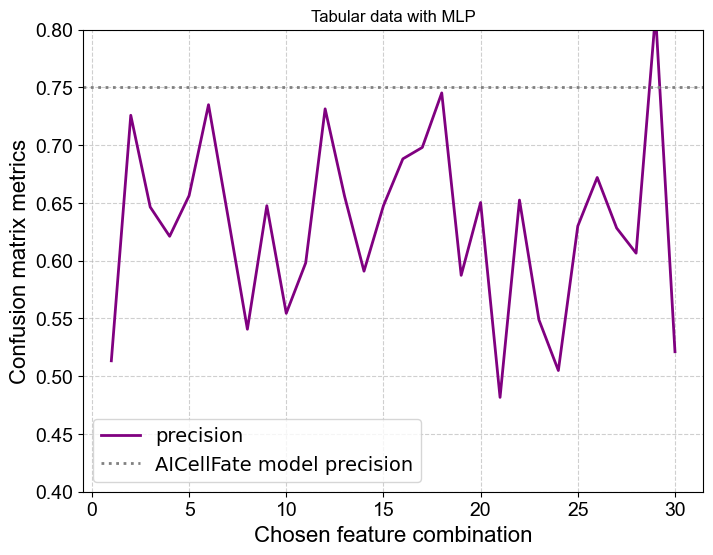

In [42]:
feature_pairs = np.arange(1, 31)

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
#plt.plot(feature_pairs, precision_tabular, color='orange', linewidth=2, label='Precision')

# Accuracy (purple)
plt.plot(feature_pairs, precision_tabular, color='purple', linewidth=2, label='precision')

# Add horizontal dotted line for AICellFate model precision
#plt.axhline(y=0.745, color='orange', linestyle='dotted', linewidth=2, label='AICellFate model precision')
plt.axhline(y=0.75, color='gray', linestyle='dotted', linewidth=2, label='AICellFate model precision') ### this is the mean precision value from AICellFate on the first frame

# # False Positives (green)
# plt.plot(feature_pairs, false_positives_tabular, color='green', linewidth=2, label='False Positives')

# # False Negatives (blue)
# plt.plot(feature_pairs, false_negatives_tabular, color='blue', linewidth=2, label='False Negatives')

# Formatting
plt.xlabel("Chosen feature combination", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.4, 0.8)  # Set y-axis range
plt.title("Tabular data with MLP")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("precision_comparison.svg", dpi=300, bbox_inches="tight")
plt.show()